In [2]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 9.0MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 1.2MB 17.9MB/s 
     |████████████████████████████████| 194kB 17.6MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 


In [3]:
from fastai.vision.all import *
from fastbook import *

In [4]:
path = untar_data(URLs.PASCAL_2007)

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [6]:
dblock = DataBlock()

In [7]:
dsets = dblock.datasets(df)

In [8]:
dsets.train[0]

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [9]:
dblock = DataBlock(get_x = lambda x: x['fname'], get_y = lambda x: x['labels'])

In [10]:
dsets = dblock.datasets(df)

In [11]:
dsets.train[0]

('005620.jpg', 'aeroplane')

In [12]:
def get_x(x): return x['fname']
def get_y(x): return x['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[1]

('005378.jpg', 'chair')

In [13]:
def get_x(x): return path/'train'/x['fname']
def get_y(x): return x['labels'].split(' ') # This is the standard split from https://docs.python.org/3/library/stdtypes.html#str.split and does not accept regexes
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[1]

(Path('/root/.fastai/data/pascal_2007/train/009596.jpg'),
 ['motorbike', 'person', 'car'])

In [14]:
def get_x(x): return path/'train'/x['fname']
def get_y(x): return x['labels'].split(' ') # This is the standard split from https://docs.python.org/3/library/stdtypes.html#str.split and does not accept regexes
dblock = DataBlock(blocks = [ImageBlock, MultiCategoryBlock], get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[1]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]))

In [15]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [16]:
def my_splitter(df):
    train = df.index[~df.is_valid].to_list()
    valid = df.index[df.is_valid].to_list()
    return train, valid

In [17]:
def get_x(x): return path/'train'/x['fname']
def get_y(x): return x['labels'].split(' ') # This is the standard split from https://docs.python.org/3/library/stdtypes.html#str.split and does not accept regexes
dblock = DataBlock(blocks = [ImageBlock, MultiCategoryBlock], get_x = get_x, get_y = get_y, splitter=my_splitter, item_tfms=[RandomResizedCrop(128, min_scale = 0.35)])
dsets = dblock.datasets(df)
dsets.train[1]
dls = dblock.dataloaders(df)

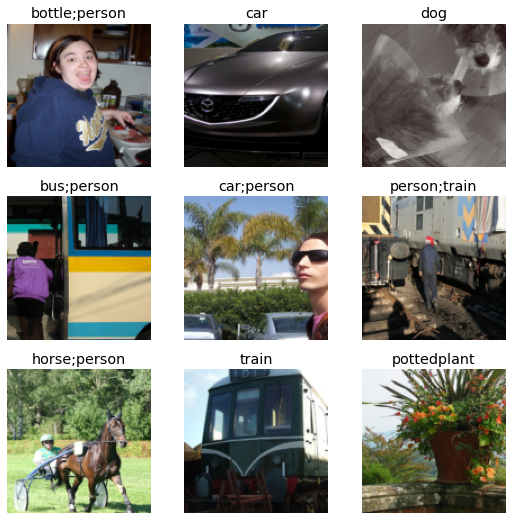

In [22]:
dls.show_batch()

In [23]:
learn = cnn_learner(dls, resnet18)

In [25]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [27]:
activs[0].sigmoid()

tensor([0.9179, 0.6287, 0.2471, 0.0529, 0.1986, 0.8546, 0.5709, 0.9289, 0.8418, 0.1915, 0.0118, 0.9722, 0.5672, 0.6308, 0.8450, 0.0326, 0.6598, 0.8553, 0.8783, 0.2195], grad_fn=<SigmoidBackward>)

In [28]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets == 1., 1-inputs, inputs).log().mean()

# The prediction that we have is a number from 0 to 1 (after the sigmoid)
# If the target is 1 we want our prediction to be close to 1 and the opposite if the target is 0
# After the where part, we have some losses which are all below 1 and we take the log which results in a negative loss
# Afterwards we take the mean of those losses and finally we multiply by -1 in order to convert the number back to a positive

In [31]:
binary_cross_entropy(activs, y)

TensorMultiCategory(1.0661, grad_fn=<AliasBackward>)

In [33]:
loss_func = nn.BCEWithLogitsLoss()
loss_func(activs, y)

TensorMultiCategory(1.0203, grad_fn=<AliasBackward>)

In [45]:
# Defining multi label accuracy
def multi_label_accuracy(preds, targets, thresh = 0.2, sigmoid = True):
    if sigmoid: preds = preds.sigmoid()
    return ((preds >= thresh) == (targets.bool())).float().mean()

In [47]:
learn = cnn_learner(dls, resnet50, metrics=partial(multi_label_accuracy, thresh = 0.5))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [48]:
learn.fine_tune(3, base_lr = 3e-3, freeze_epochs = 4)

epoch,train_loss,valid_loss,multi_label_accuracy,time
0,0.942972,0.698873,0.625578,00:29
1,0.825799,0.563647,0.732430,00:30
2,0.607073,0.211818,0.946514,00:29
3,0.362917,0.124616,0.957869,00:29


epoch,train_loss,valid_loss,multi_label_accuracy,time
0,0.134659,0.117970,0.958904,00:30
1,0.117041,0.104242,0.963785,00:31
2,0.097539,0.100703,0.964263,00:30
